In [215]:
import numpy as numpy
import pandas as pd
import math 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#create function to identify which galaxy an x-ray flash or variable star is in
#home function (because it finds star's home)
def home(ax, ay, bx, by, length):
    closestradius=1e12
    for counter in range (0, length):
        #radius is distance between star/flash and galaxy
        radius=math.sqrt((ax[counter]-bx)**2+(ay[counter]-by)**2)
        if radius< closestradius:
            closestradius=radius 
            #value is the identifier of the galaxy we have found the star/flash to be closest to
            value=counter
    return value

#read in data from AllGalaxies
gData = pd.read_csv("AllGalaxies.csv", index_col="Name")
gx = gData['X'].to_numpy() #x coord of galaxy 
gy = gData['Y'].to_numpy()
length=len(gx)
gdlist =[0.0]*length

#read in data from LongVariables.csv to a panda and then into numpy arrays
vData = pd.read_csv("universe_8/Long Variables.csv", index_col="Name")
vx = vData['X'].to_numpy() #x-coord of variable star
vy = vData['Y'].to_numpy()
vdlist=vData['Distance'].to_numpy() #distance of star from NewEarth 

#read in data from x-ray flashes
flashData = pd.read_csv("universe_8/Flash_Data.csv", index_col="Name")
fx = flashData['X'].to_numpy() #x cood of flash 
fy = flashData['Y'].to_numpy()
fp=flashData['Photon-Count'].to_numpy()
n=len(fx)
fXlist=[0.0]*n
fdlist =[0.0]*n

In [176]:
#identify a home galaxy for each of the variable star
l=len(vx)

#repeat for every star
for star in range(0, l):
    #get coords of star
    bx=vx[star]
    by=vy[star]
    #find home galaxy
    answer=home(gx, gy, bx, by, length) #returns index of home galaxy 
    gdlist[answer]=vdlist[star]

In [177]:
#identify k closest flashes
k=7
highestFlashes=flashData.nlargest(k,'Photon-Count')

#numpy arrays hfx means x co-ord of highest flash 
print(highestFlashes)
hfx = highestFlashes['X'].to_numpy()
hfy = highestFlashes['Y'].to_numpy()
#hfi=highestFlashes['I'].to_numpy()
photonCountList = highestFlashes['Photon-Count'].to_numpy()
hfdlist =[0]*k


     Direction      X      Y  Photon-Count
Name                                      
FE07     Right -15.22 -10.73      11308305
FE17     Right -37.66   2.63       7815723
FE21     Right -14.38  12.72        335458
FE34    Bottom   7.08 -38.33        197713
FE23      Back  34.87  30.66         84349
FE44      Back  26.00  27.46         84315
FE37       Top   0.08  26.27         82567


In [178]:
#identify a home galaxy for each of the highest flashes

#repeat for every flash 
for i in range(0, k):
    #get coords of x-ray flash
    bx=hfx[i]
    by=hfy[i]
    #find home galaxy
    identifier=home(gx, gy, bx, by, length) #returns index of home galaxy 

    #distance of the xray flash= distance of closest galaxy 
    hfdlist[i]=gdlist[identifier]

 

In [179]:
#plot distance versus photon count for highest x-ray flashes

xList=[0.0]*k

#x=1/d^2, find x for each d and store in parallel array
for a in range (0, k):
    if hfdlist[a]>0:
        xList[a]=1/(hfdlist[a]**2)

graphdf = pd.DataFrame(data=[xList, photonCountList], index=['newxlist', 'plist']).T
graphdf.query('newxlist>0', inplace=True)
finalxlist = graphdf['newxlist'].to_numpy()
finalplist = graphdf['plist'].to_numpy()



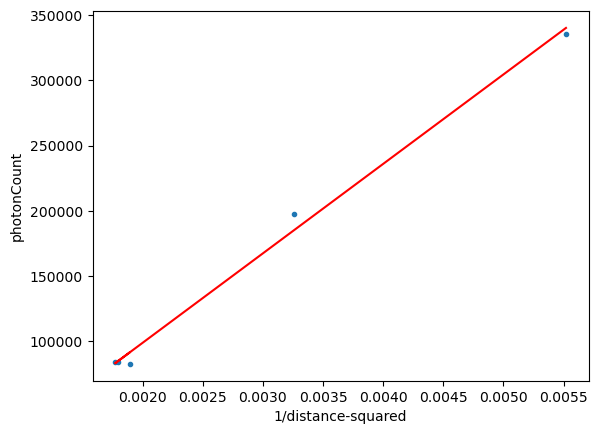

In [180]:
#plot line and find gradient m

A = numpy.vander(finalxlist,2) 
# the Vandermonde matrix of order N is the matrix of polynomials of an input vector 1, x, x**2, etc

b, residuals, rank, s = numpy.linalg.lstsq(A,finalplist)
#print('parameters: %.2f, %.2f' % (b[0],b[1]))
m=b[0]

reconstructed = A @ b # @ is shorthand for matrix multiplication in python

plt.plot(finalxlist,finalplist,'.')
plt.plot(finalxlist,reconstructed,'-r')
plt.xlabel("1/distance-squared")
plt.ylabel("photonCount")
plt.show()

In [181]:
def monte_carlo(xdata, xuncs, ydata, yuncs, iterations):

    # initialise arrays to store our data in
    grads = np.zeros(iterations)
    yints = np.zeros(iterations)
    x_rand = np.zeros(len(xdata))
    y_rand = np.zeros(len(xdata))
    #print(x_rand)
    
    # if our uncertainty is a scalar, make it an array with N times that value (N being the length of our data array)
    if np.size(xuncs) == 1:
        xuncs = np.ones(len(xdata)) * xuncs
    if np.size(yuncs) == 1:
        yuncs = np.ones(len(ydata)) * yuncs
    
    # now to perform n=iterations random samples of our data distributions
    for i in range(iterations):
        for j in range(len(xdata)):
            # generate a random normal variable for each of our XY data points
            x_rand[j] = np.random.normal(xdata[j], xuncs[j])
            y_rand[j] = np.random.normal(ydata[j], yuncs[j])
            
            
        # now fit a line to our random data. A 1-dimensional polynomial is just a straight line!
        grads[i], yints[i] = np.polyfit(x_rand, y_rand, 1)
        
    
    # now get the statistics of our *iterations* number of trendline parameters
    meangrad = np.mean(grads[:i])
    SDgrad = np.std(grads[:i])
    meanyint = np.mean(yints[:i])
    SDyint = np.std(yints[:i])
    return np.array([meangrad, SDgrad, meanyint, SDyint])



46


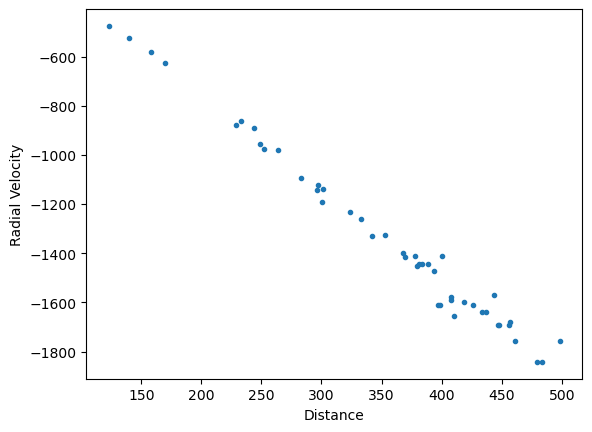

In [182]:
#new flashData column distance 
fXlist= fp/m
fdlist=numpy.sqrt(1/fXlist)

newgdlist=[0.0]*length
#find galaxy for each flash 
for q in range(0, n):
    #get coords of x-ray flash
    bx=fx[q]
    by=fy[q]
    #find home galaxy
    p=home(gx, gy, bx, by, length) #returns index of home galaxy 

    #save distance for each galaxy 
    newgdlist[p]=fdlist[q]

#filter galaxies with distance greater than 0
gData['Distance'] = newgdlist
gData.query('Distance>60.0', inplace=True)
print(len(gData.index))

DistanceList = gData['Distance'].to_numpy()
VelocityList = gData['RadialVelocity'].to_numpy()

plt.plot(DistanceList,VelocityList,'.')
plt.xlabel("Distance")
plt.ylabel("Radial Velocity")
plt.show()

[410.44169143 407.94354472 418.22081092 283.34773015 479.66777338
 483.74318879 341.76660372 352.75475278 426.4597011  397.01237567
 398.38850589 498.41847523 461.44584247 381.53836976 389.04476184
 383.99201801 379.13116359 233.27242317 158.18794779 434.00824643
 437.02013716 229.03975977 263.96790405 332.54684245 407.94354472
 243.43442518 367.7432362  297.43893816 455.81824362 447.09685328
 447.75002653 369.93873771 251.96301445 295.91555331 443.87332996
 248.87132663 301.55254655 324.03511971 456.51045092 123.10831161
 300.75584094 169.44607447 377.55144354 400.24580503 139.50582819
 393.41128199]
[-1653.82 -1576.38 -1597.16 -1092.4  -1842.33 -1842.2  -1328.13 -1327.69
 -1610.56 -1610.63 -1610.63 -1758.53 -1758.28 -1442.87 -1443.37 -1443.05
 -1452.53  -862.23  -580.03 -1637.9  -1637.89  -878.35  -981.08 -1261.35
 -1589.52  -890.32 -1400.   -1122.23 -1690.92 -1691.18 -1691.31 -1416.68
  -973.94 -1141.39 -1570.19  -953.74 -1137.32 -1231.24 -1680.93  -475.01
 -1189.95  -624.87 -1409.3

AttributeError: Line2D.set() got an unexpected keyword argument 's'

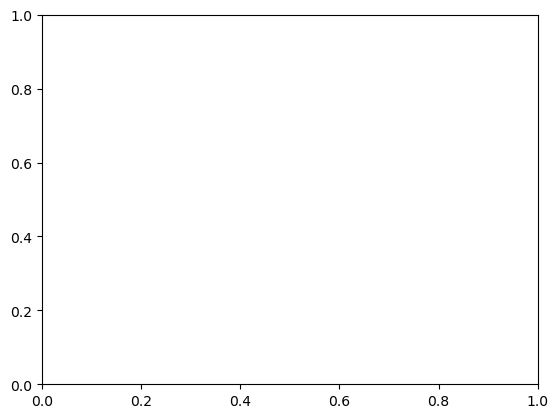

In [214]:
#plot line and find gradient m


A2 = numpy.vander(DistanceList,2) 
# the Vandermonde matrix of order N is the matrix of polynomials of an input vector 1, x, x**2, etc

b2, residuals2, rank2, s2 = numpy.linalg.lstsq(A2,VelocityList)
#print('parameters: %.2f, %.2f' % (b2[0],b2[1]))
m2=b2[0]


std_dev = 10  # Arbitrary value

# Number of Monte Carlo samples
num_samples = 10000  # You can adjust this as needed
values = [410.44169143, 407.94354472, 418.22081092, 283.34773015, 479.66777338,
          483.74318879, 341.76660372, 352.75475278, 426.4597011,  397.01237567,
          398.38850589, 498.41847523, 461.44584247, 381.53836976, 389.04476184,
          383.99201801, 379.13116359, 233.27242317, 158.18794779, 434.00824643,
          437.02013716, 229.03975977, 263.96790405, 332.54684245, 407.94354472,
          243.43442518, 367.7432362,  297.43893816, 455.81824362, 447.09685328,
          447.75002653, 369.93873771, 251.96301445, 295.91555331, 443.87332996,
          248.87132663, 301.55254655, 324.03511971, 456.51045092, 123.10831161,
          300.75584094, 169.44607447, 377.55144354, 400.24580503, 139.50582819,
          393.41128199]
velvals = [-1653.82 -1576.38 -1597.16 -1092.4  -1842.33 -1842.2  -1328.13 -1327.69
 -1610.56 -1610.63 -1610.63 -1758.53 -1758.28 -1442.87 -1443.37 -1443.05
 -1452.53  -862.23  -580.03 -1637.9  -1637.89  -878.35  -981.08 -1261.35
 -1589.52  -890.32 -1400.   -1122.23 -1690.92 -1691.18 -1691.31 -1416.68
  -973.94 -1141.39 -1570.19  -953.74 -1137.32 -1231.24 -1680.93  -475.01
 -1189.95  -624.87 -1409.36 -1409.6   -525.46 -1472.02]
# Generate Monte Carlo samples
monte_carlo_samples = []
for value in values:
    mc_samples = np.random.normal(loc=value, scale=std_dev, size=num_samples)
    monte_carlo_samples.append(mc_samples)

# Calculate uncertainty as standard deviation of the Monte Carlo samples
uncertainties = [np.std(mc_samples) for mc_samples in monte_carlo_samples]
avg = 0
for i, uncertainty in enumerate(uncertainties, 1):
    avg += uncertainty


monte_carlo_samples_vels = []
for value in velvals:
    mc_samples = np.random.normal(loc=velvals, scale=std_dev, size=num_samples)
    monte_carlo_samples_vels.append(mc_samples)

# Calculate uncertainty as standard deviation of the Monte Carlo samples
uncertainties_vel = [np.std(mc_samples) for mc_samples in monte_carlo_samples_vels]
avg = 0
for i, uncertainty in enumerate(uncertainties_vel, 1):
    avg += uncertainty
uncert_vel= avg/len(uncertainties)

SE_m = uncert_vel / (np.sqrt(46) * uncert)

reconstructed2 = A2 @ b2 # @ is shorthand for matrix multiplication in python
print(DistanceList)
print(VelocityList)
plt.errorbar(DistanceList,VelocityList, xerr= uncertainties, yerr = uncertainties_vel, fmt='.', s= 0.5)
plt.plot(DistanceList,reconstructed2,'-r')


plt.xlabel("Distance")
plt.ylabel("Radial Velocity")
plt.show()

print("The hubble constant is:"+ str(m2) +"+-"+ str(SE_m))

# some tinkering around to get a nicer H value (neha)

In [114]:
import pandas as pd

datapath = 'universe_8' 
xrayData = pd.read_csv(datapath + '/Flash_Data.csv')
galaxDists = pd.read_csv(datapath + '/Galaxy_Distances.csv', delimiter=' ')

emily's code 2.0

In [115]:
#read in data from AllGalaxies
gData = pd.read_csv("AllGalaxies.csv", index_col="Name")
gx = gData['X'].to_numpy() #x coord of galaxy 
gy = gData['Y'].to_numpy()
length=len(gx)
gdlist =[0.0]*length

#read in data from LongVariables.csv to a panda and then into numpy arrays
vData = pd.read_csv("universe_8/Long Variables.csv", index_col="Name")
vx = vData['X'].to_numpy() #x-coord of variable star
vy = vData['Y'].to_numpy()
vdlist=vData['Distance'].to_numpy() #distance of star from NewEarth 

#read in data from x-ray flashes
flashData = pd.read_csv("universe_8/Flash_Data.csv", index_col="Name")
fx = flashData['X'].to_numpy() #x cood of flash 
fy = flashData['Y'].to_numpy()
fp=flashData['Photon-Count'].to_numpy()
n=len(fx)
fXlist=[0.0]*n
fdlist =[0.0]*n

In [116]:
import numpy as np

closeflashes = xrayData.loc[flashData['Photon-Count'].to_numpy() > 1e6]
print(closeflashes)

    Name Direction      X      Y  Photon-Count
6   FE07     Right -15.22 -10.73      11308305
16  FE17     Right -37.66   2.63       7815723


In [118]:
lumins = []
delta = 1.5

for i, flash in closeflashes.iterrows():
    for j, equat in enumerate(fx):
        if (flash['X'] - delta <= equat <= flash['X'] + delta
           ) and (flash['Y'] - delta <= fy[j] <= flash['Y'] + delta):
            lumin = flash['Photon-Count'] * 4 * np.pi * vdlist[j]**2
            lumins.append(lumin)
lumins = np.array(lumins)
print(lumins)

[1.06135376e+11 9.33154035e+10]


In [128]:
base_lumin = np.mean(lumins)
xraydists = np.zeros(len(xrayData))
for i, flash in xrayData.iterrows():
    xraydists[i] = np.sqrt(base_lumin / (4 * np.pi * flash['Photon-Count']))

print(xraydists)

[5160.47652315 4388.83577788 4775.38418382 4903.89280986 3486.11209829
 4271.23346148   26.49105058 1822.97527113 4588.0407184  4669.25128357
 1500.86495526 2464.11030453 4415.71193708 1324.45327191 4499.40312025
 3244.23470434   31.86495864 4817.09138778 5204.32163155 3956.34320727
  153.80797769 4388.83577788  306.73121123 4415.71193708 3795.09052134
 3183.58945588 4232.49131442 3235.66339556 3676.87518891 4810.06426313
 4104.75731143 3577.68494887 5362.20480688  200.34583842 4078.85953043
 2710.72874374  310.02355081 4911.33987992 2677.46700868 3199.9786991
 3979.96337657 4701.6545265  3048.37929602  306.79304964 4061.86420846
 1701.85540097 4306.02011422  531.45679352 4286.03847455 2509.64715598
 2618.97443556 2839.88261736 4964.4369893  4131.15473661 4185.51437332]


In [129]:
distGalaxData = pd.read_csv('Distant_Galaxies_Combined.csv')
speeds = np.zeros(len(xrayData))
delta = 0.5
for i, flash in xrayData.iterrows():
    for j, equat in enumerate(distGalaxData['X']):
        if (flash['X'] - delta <= equat <= flash['X'] + delta
           ) and (flash['Y'] - delta <= distGalaxData['Y'][j] <= flash['Y'] + delta):
            speeds[i] = distGalaxData['RadialVelocity'][j]

      Unnamed: 0        Name        X        Y         BlueF        GreenF  \
0              0  BackDG0050  -8.2964 -27.6046  8.485000e-18  7.266000e-18   
1              1  BackDG0051  -8.2302 -27.7291  1.178000e-17  9.976000e-18   
2              2  BackDG0052  -8.3449 -27.6217  1.270000e-17  9.513000e-18   
3              3  BackDG0053  -8.4188 -27.5488  1.311000e-17  1.080000e-17   
4              4  BackDG0054  -8.3127 -27.4879  8.319000e-18  7.351000e-18   
...          ...         ...      ...      ...           ...           ...   
1436         185   TopDG1432 -26.2365  18.1013  5.071000e-17  4.074000e-17   
1437         186   TopDG1433 -25.9541  18.3029  4.546000e-17  3.497000e-17   
1438         187   TopDG1434 -27.0990  17.8371  4.674000e-17  4.334000e-17   
1439         188   TopDG1435 -26.0658  18.0862  4.762000e-17  3.656000e-17   
1440         189   TopDG1436 -26.5360  18.2018  6.094000e-17  5.226000e-17   

              RedF      Size  RadialVelocity  
0     3.064000e-

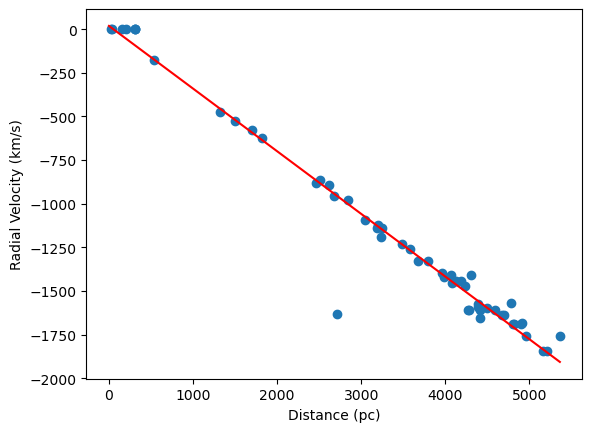

In [135]:
import matplotlib.pyplot as plt

grad, yint = np.polyfit(xraydists, speeds, 1)
print(distGalaxData)
xvals = np.array([0, max(xraydists)])

print(f"m = {round(grad * 1e6, 2)} km/s/Mpc; y-int = {round(yint, 2)} km/s")

fig, ax = plt.subplots()
ax.scatter(xraydists, speeds)
ax.plot(xvals, grad * xvals + yint, 'r-')
ax.set_xlabel("Distance (pc)");
ax.set_ylabel("Radial Velocity (km/s)");


# Homogeneity

In [136]:
distGalaxData['Distance'] = (distGalaxData['RadialVelocity'].to_numpy() - yint) / grad

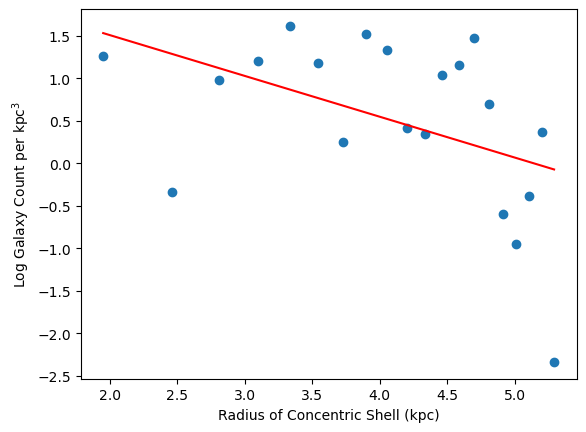

In [137]:
volume = 4 * np.pi * max(distGalaxData['Distance'])**3 / 3
subdivisions = 20
sub_vol = volume / subdivisions

radii = np.zeros(subdivisions)
for i in range(subdivisions):
    radii[i] = np.cbrt(3 * ((i + 1) * volume / subdivisions) / (4 * np.pi)) # this finds the radii for equal volume shells
    
counts = np.zeros(subdivisions)
for i, radius in enumerate(radii):
    prev = 0 if i == 0 else radii[i - 1]
    
    close_count = len(galaxDists.loc[(galaxDists['MS_distance'] > prev) & (galaxDists['MS_distance'] <= radius)])
    far_count = len(distGalaxData.loc[(distGalaxData['Distance'] > prev) & (distGalaxData['Distance'] <= radius)])
    counts[i] = close_count + far_count

grad, yint = np.polyfit(radii / 1e3, np.log(1e3**3 * counts / sub_vol), 1)

fig, ax = plt.subplots()
ax.scatter(radii / 1e3, np.log(1e3**3 * counts / sub_vol))
ax.plot(radii / 1e3, grad * radii / 1e3 + yint, 'r')
ax.set_xlabel("Radius of Concentric Shell (kpc)")
ax.set_ylabel("Log Galaxy Count per kpc$^3$");


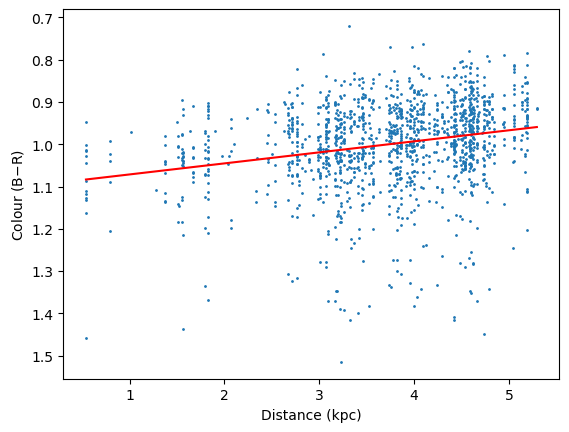

In [138]:
B_V = np.log(distGalaxData['BlueF'] / distGalaxData['RedF'])

grad, yint = np.polyfit(distGalaxData['Distance'] / 1e3, B_V, 1)
xvals = np.array([min(distGalaxData['Distance'] / 1e3), max(distGalaxData['Distance'] / 1e3)])

fig, ax = plt.subplots()
ax.scatter(distGalaxData['Distance'] / 1e3, B_V, s=1)
ax.plot(xvals, grad * xvals + yint, 'r')
ax.invert_yaxis()
ax.set_xlabel("Distance (kpc)")
ax.set_ylabel("Colour (B$-$R)");